In [2]:
%load_ext autoreload
%autoreload 2

In [11]:
!pip install --no-index scikit-learn

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic/scikit_learn-1.6.1+computecanada-cp311-cp311-linux_x86_64.whl
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/threadpoolctl-3.5.0+computecanada-py3-none-any.whl (from scikit-learn)


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import zscore

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

from clean_functions import load_neural_data, make_a_plot_beautiful, transpose_neural_data, select_contents, generate_times

In [7]:
# Load the neural data
neural_data_path = "mag_wm_data.mat"
contents = [f"r{i}" for i in range(1, 7)]

neural_data = load_neural_data(file_path=neural_data_path, contents=contents)

# preprocess neural data
neural_data = transpose_neural_data(neural_data) # reps, imgs, ns, tb

# only select the time bins between 180ms-540ms (6-18)

for key, value in neural_data.items():
    neural_data[key] = value[:, :, :, 6:19]

for key, value in neural_data.items():
    print(f"{key}: {value.shape}")


# take average over reps, imgs
for key, value in neural_data.items():
    neural_data[key] = np.nanmean(value, axis=(0)) # reps, images

for key, value in neural_data.items():
    print(f"{key}: {value.shape}")

# load labels
lbls = pd.read_csv("/home/soroush1/projects/def-kohitij/soroush1/WM_age_of_ultron/data/hvm200/working_memory_images_labels.csv")
lbls = lbls.values

lbls[:10], lbls.shape

r1: (16, 200, 192, 13)
r2: (16, 200, 192, 13)
r3: (16, 200, 192, 13)
r4: (16, 200, 192, 13)
r5: (16, 200, 192, 13)
r6: (16, 200, 192, 13)
r1: (200, 192, 13)
r2: (200, 192, 13)
r3: (200, 192, 13)
r4: (200, 192, 13)
r5: (200, 192, 13)
r6: (200, 192, 13)


(array([['bear'],
        ['bear'],
        ['bear'],
        ['bear'],
        ['bear'],
        ['bear'],
        ['bear'],
        ['bear'],
        ['bear'],
        ['bear']], dtype=object),
 (200, 1))

In [14]:
def get_model():
    clf = SGDClassifier(
    loss="log_loss",            # Logistic regression
    penalty="l2",          # Ridge regression (L2 regularization)
    alpha=0.0001,
    max_iter=20000,        # Iteration limit
    tol=None,              # No early stopping
    learning_rate="optimal",
    n_jobs=4,
    )
    
    return OneVsRestClassifier(clf)

In [19]:
nfolds = 5
# Define window parameters
window_size = 3
num_windows = 13  # Max index for windows

kf = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=42)

accs = []

for start in range(0, num_windows - window_size + 1):
    end = start + window_size
    print(f"{start} : {end}")
    
    # Compute mean across the window
    X = np.nanmean(neural_data["r4"][:, :, start:end], axis=2)
    y = lbls.copy()
    print(f"r4: {r4.shape}")
    
    folds_accs = []
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"\t\tfold {fold + 1}")
        tr = X[tr_idx]
        y_tr = y[tr_idx]
        val = X[val_idx]
        y_val = y[val_idx]

        print(f"{tr.mean()}")
        print(f"{val.mean()}")
        
        print(f"\t\t\ty_tr: {np.unique(y_tr)} {y_tr.shape}")
        print(f"\t\t\ty_val: {np.unique(y_val)} {y_val.shape}")

        multi_clf = get_model()
    
        multi_clf.fit(tr, y_tr)
        y_preds = multi_clf.predict(val)
        print(f"acc: {accuracy_score(y_val, y_preds)}")
        folds_accs.append(accuracy_score(y_val, y_preds))

    accs.append(folds_accs)

accs = np.array(accs)
np.save("400ms_sliding_window_decoder_180_540ms.npy", accs)

0 : 3
r4: (200, 192)
		fold 1
0.04058972925244651
0.04407295285846392
			y_tr: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (160, 1)
			y_val: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (40, 1)
acc: 0.475
		fold 2
0.04101450682064015
0.04237384258568937
			y_tr: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (160, 1)
			y_val: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (40, 1)
acc: 0.475
		fold 3
0.042004181722155844
0.038415142979626574
			y_tr: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (160, 1)
			y_val: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (40, 1)
acc: 0.575
		fold 4
0.04157412490737696
0.04013537023874211
			y_tr: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (160, 1)
			y_val: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'e

In [18]:
accs = np.array(accs)
np.save("400ms_sliding_window_decoder_180_540ms.npy", accs)

In [23]:
from scipy.stats import shapiro, kruskal
import seaborn as sns

In [15]:
# first we want to perform statistic on the first sliding window
r4 = np.nanmean(neural_data["r4"][:, 9:13], axis=1)
r5 = np.nanmean(neural_data["r5"][:, 9:13], axis=1)
r6 = np.nanmean(neural_data["r6"][:, 9:13], axis=1)

shapiro(r4).pvalue, shapiro(r5).pvalue, shapiro(r6).pvalue

# I checked and non of the sliding windows wasn't normal, so we select Kruskal-Wallis test (non-parametric) over ANOVA

(1.4950351092068096e-13, 2.0334484489191755e-13, 4.524785897223965e-14)

In [28]:
# plot sliding accuracies
delay_sliding_window_acc = {
    400: np.load("400ms_sliding_window_decoder_180_540ms.npy"),
    800: np.load("800ms_sliding_window_decoder_180_540ms.npy"),
    1200: np.load("1200_sliding_window_decoder_180_540ms.npy"),
}

delay_400ms = np.load("400ms_sliding_window_decoder_180_540ms.npy")
delay_800ms = np.load("800ms_sliding_window_decoder_180_540ms.npy")
delay_1200ms = np.load("1200_sliding_window_decoder_180_540ms.npy")
delay_400ms.shape, delay_800ms.shape, delay_1200ms.shape, delay_400ms.mean(), delay_800ms.mean(), delay_1200ms.mean()

((11, 5), (11, 5), (11, 5), 0.27045454545454545, 0.265, 0.26045454545454544)

In [22]:
delay_400ms.mean(), delay_800ms.mean(), delay_1200ms.mean()

(0.27045454545454545, 0.265, 0.26045454545454544)

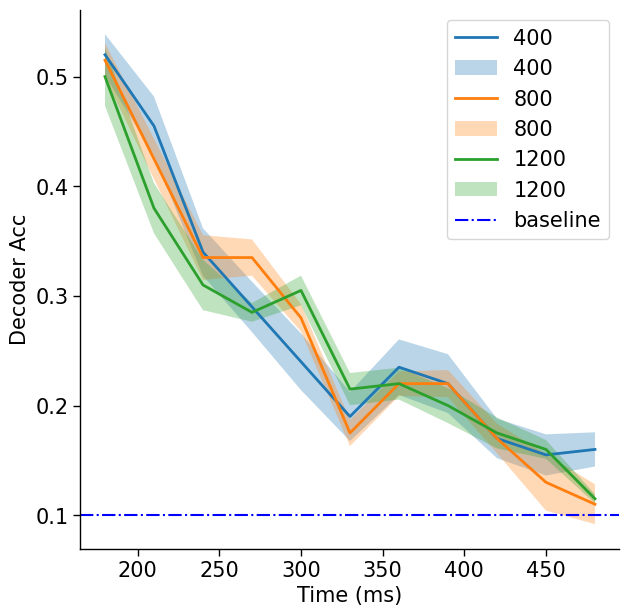

In [32]:
# Extracting window start indices and p-values
window_starts = np.array([180 + res*30 for res in range(0, 11)])
fig, ax = plt.subplots(figsize=(7, 7))

for delay in [400, 800, 1200]:
    accs = delay_sliding_window_acc[delay]
    # first take an average over reps and images
    mean = np.nanmean(accs, axis=(1)) # average over folds
    sd = np.std(accs, axis=(1), ddof=1) # sd over folds
    se = sd / np.sqrt(len(accs))

    # Plot mean response
    ax.plot(window_starts, mean, linewidth=2, label=f"{delay}")
    
    # Add SE as a shaded region
    ax.fill_between(window_starts, mean - se, mean + se, alpha=0.3, label=f"{delay}")

ax.axhline(y=0.1, linestyle="-.", color="b", linewidth=1.5, label="baseline")

make_a_plot_beautiful(ax)

# Labels and legend
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Decoder Acc")
ax.legend()

plt.show()

In [34]:
delay_sliding_window_acc[400].shape

(11, 5)

In [36]:
from scipy.stats import shapiro, kruskal


In [39]:
# Store results
results = []

# Loop through each sliding window
for start in range(0, 11):
    
    # Compute mean across the window
    # r4 = np.nanmean(delay_sliding_window_acc[400], axis=1)[start]
    # r5 = np.nanmean(delay_sliding_window_acc[800], axis=1)[start]
    # r6 = np.nanmean(delay_sliding_window_acc[1200], axis=1)[start]

    r4 = delay_sliding_window_acc[400][start]
    r5 = delay_sliding_window_acc[800][start]
    r6 = delay_sliding_window_acc[1200][start]

    # Normality test
    shapiro_p_values = (shapiro(r4).pvalue, shapiro(r5).pvalue, shapiro(r6).pvalue)
    normality = all(p > 0.05 for p in shapiro_p_values)

    # Choose statistical test
    if normality:
        test_name = "ANOVA not used (data not normal)"
        kw_stat, kw_p = kruskal(r4, r5, r6)
    else:
        test_name = "Kruskal-Wallis"
        kw_stat, kw_p = kruskal(r4, r5, r6)

    # Store results
    results.append({
        "Window Start": start,
        "Window End": end,
        "Shapiro P-values": shapiro_p_values,
        "Test Used": test_name,
        "Kruskal-Wallis H": kw_stat,
        "Kruskal-Wallis P": kw_p
    })

# Print results
for res in results:
    print(res)

{'Window Start': 0, 'Window End': 13, 'Shapiro P-values': (0.024852040518542316, 0.753972996466029, 0.5005770818123318), 'Test Used': 'Kruskal-Wallis', 'Kruskal-Wallis H': 0.15926605504587274, 'Kruskal-Wallis P': 0.9234551668439761}
{'Window Start': 1, 'Window End': 13, 'Shapiro P-values': (0.41523242670712257, 0.1458437015523273, 0.9854182266624992), 'Test Used': 'ANOVA not used (data not normal)', 'Kruskal-Wallis H': 1.8615101289134435, 'Kruskal-Wallis P': 0.3942559093322704}
{'Window Start': 2, 'Window End': 13, 'Shapiro P-values': (0.7416997909897556, 0.9796155110633026, 0.5486807150698275), 'Test Used': 'ANOVA not used (data not normal)', 'Kruskal-Wallis H': 0.7715328467153239, 'Kruskal-Wallis P': 0.6799293227421901}
{'Window Start': 3, 'Window End': 13, 'Shapiro P-values': (0.18955441828009667, 0.13502259259489768, 0.813952127723689), 'Test Used': 'ANOVA not used (data not normal)', 'Kruskal-Wallis H': 2.2074906367041165, 'Kruskal-Wallis P': 0.3316267072669922}
{'Window Start': 4

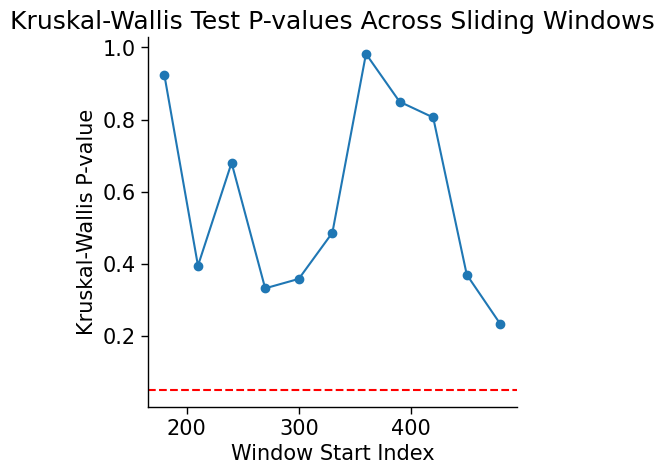

In [40]:
fig, ax = plt.subplots()

# Extracting window start indices and p-values
window_starts = [180 + res["Window Start"]*30 for res in results]
kw_p_values = [res["Kruskal-Wallis P"] for res in results]


ax.plot(window_starts, kw_p_values, marker='o', linestyle='-', label="Kruskal-Wallis P-value")
ax.axhline(y=0.05, color='r', linestyle='--', label="Significance Threshold (0.05)")

make_a_plot_beautiful(ax)

# Labels and title
plt.xlabel("Window Start Index")
plt.ylabel("Kruskal-Wallis P-value")
plt.title("Kruskal-Wallis Test P-values Across Sliding Windows")

plt.show()

In [45]:
from scipy.stats import chisquare

# Store results
results = []

# Loop through each sliding window
for start in range(0, 11):
    
    #Compute mean across the window
    r4 = np.nanmean(delay_sliding_window_acc[400], axis=1)[start]
    r5 = np.nanmean(delay_sliding_window_acc[800], axis=1)[start]
    r6 = np.nanmean(delay_sliding_window_acc[1200], axis=1)[start]

    print(f"{r4}, {r5}, {r6}")

    # r4 = delay_sliding_window_acc[400][start]
    # r5 = delay_sliding_window_acc[800][start]
    # r6 = delay_sliding_window_acc[1200][start]
    chi_stat, chi_p = chisquare([r4, r5, r6])
    # Store results
    results.append({
        "Window Start": start,
        "Window End": end,
        "pvalue-chi-square": chi_p,
    })

# Print results
for res in results:
    print(res)

0.52, 0.515, 0.4999999999999999
0.45499999999999996, 0.425, 0.38
0.33999999999999997, 0.335, 0.31
0.29, 0.335, 0.285
0.24, 0.28, 0.305
0.19, 0.175, 0.21500000000000002
0.23500000000000001, 0.22000000000000003, 0.22000000000000003
0.22000000000000003, 0.22000000000000003, 0.2
0.17, 0.17, 0.175
0.155, 0.13, 0.16
0.16, 0.11000000000000001, 0.11499999999999999
{'Window Start': 0, 'Window End': 13, 'pvalue-chi-square': 0.9997882960280843}
{'Window Start': 1, 'Window End': 13, 'pvalue-chi-square': 0.9966128920929889}
{'Window Start': 2, 'Window End': 13, 'pvalue-chi-square': 0.9992135074170974}
{'Window Start': 3, 'Window End': 13, 'pvalue-chi-square': 0.9975031223974601}
{'Window Start': 4, 'Window End': 13, 'pvalue-chi-square': 0.9960985396407012}
{'Window Start': 5, 'Window End': 13, 'pvalue-chi-square': 0.9978901598827038}
{'Window Start': 6, 'Window End': 13, 'pvalue-chi-square': 0.9996667222160499}
{'Window Start': 7, 'Window End': 13, 'pvalue-chi-square': 0.9993751952718163}
{'Window 

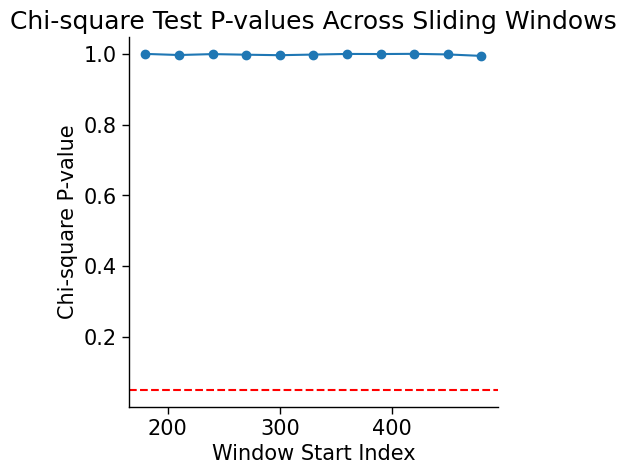

In [46]:
fig, ax = plt.subplots()

# Extracting window start indices and p-values
window_starts = [180 + res["Window Start"]*30 for res in results]
kw_p_values = [res["pvalue-chi-square"] for res in results]


ax.plot(window_starts, kw_p_values, marker='o', linestyle='-', label="Kruskal-Wallis P-value")
ax.axhline(y=0.05, color='r', linestyle='--', label="Significance Threshold (0.05)")

make_a_plot_beautiful(ax)

# Labels and title
plt.xlabel("Window Start Index")
plt.ylabel("Chi-square P-value")
plt.title("Chi-square Test P-values Across Sliding Windows")

plt.show()